In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.interpolate 
import re
import csv
import warnings
import json
import matplotlib
# matplotlib.use('tkAgg') # 'tkAgg' if Qt not present 
import scipy as sp
import matplotlib.animation as animation
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Data location
path_of_the_directory= "C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/INTERPODATA/"

data_files = []
file_names = []

Saving_Folder_adress= "C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/Interpolated data/"

#Storing in a list the adresses of all the data files in the notebook
for filename in os.listdir(path_of_the_directory):
    f = os.path.join(path_of_the_directory,filename)
    if os.path.isfile(f):
        data_files.append(f)
        file_names.append(filename)
                              
# removing special character for the upper limits 
special_char = re.compile('<')

#Function to convert from strings to float and separate upper limits
#and flux data points

def Filterup(data):
    
    Flux= data['Photon Flux [0.1-100 GeV](photons cm-2 s-1)']
    Time = data['Julian Date']
    
    Flux = np.array(Flux)
    Time=Time.astype(float)
    
    #Non upperlimits flux data and corresponding index
    FLUXTIME = []
    FLUXTIME_index = []
    
    
    UPTIME = []
    UpperLINDEX=  []
    UpperLimits=[]
    
    for i in range(len(Flux)):
        
        if(special_char.search(Flux[i]) == None):
                FLUXTIME.append(Time[i])
                FLUXTIME_index.append(i)
        else:  
            UpperLINDEX.append(i)            
            Flux[i]=Flux[i].replace('< ', '')
            
            UPTIME.append(Time[i])
            
    Flux=Flux.astype(float)
    FULL_FLUX_array=Flux.copy()
    FULL_TIME=Time.copy()
    
    for j in range(len(UpperLINDEX)):
        
        j=0
        i = UpperLINDEX[j]-j
        UpperLimits.append(Flux[i])
        Flux = np.delete(Flux,i)
        j=j-1
        
    
    UpperLimits=np.array(UpperLimits)    
    UpperLimits=UpperLimits.astype(float)
    UPTIME=np.array(UPTIME) 
    UPTIME=UPTIME.astype(float)
    
    return Flux,UpperLimits,FLUXTIME,UpperLINDEX,UPTIME,FLUXTIME_index,FULL_TIME,FULL_FLUX_array








#Looping with data files
#Interpolation/extrapolation code

# for i in range(3):



file_adress = data_files[8]
LC=pd.read_csv(file_adress)

Interp_proj=[]
LSTM_proj = []

Bspline_proj = []

interpolated_flux=[]
extrapolated_flux1= []
extrapolated_flux2= []
Bspline_interpolation = []


#Function calling
FLUX_points,UP,JD,UPindex,UPTIME,FTI,FT_array,FF_array= Filterup(LC)
print(len(UPindex))
#Linear interpolation and extrapolation
flux_extrapolate = scipy.interpolate.interp1d(JD,FLUX_points,fill_value='extrapolate')
flux_interp = scipy.interpolate.interp1d(JD, FLUX_points)
#Bspline interpolation

tck = scipy.interpolate.splrep(JD, FLUX_points, s=1)



if FTI[0]>UPindex[0]:

    for j in range(FTI[0]):
        a = flux_extrapolate(FT_array[j])
        extrapolated_flux1.append(a)
        Bspline_interpolation.append(a)
        FF_array[j]=a

    UPindex = [x for x in UPindex if x>FTI[0]]
    Interp_proj=extrapolated_flux1    
    Bspline_proj = extrapolated_flux1  

else : 
        UPindex = [x for x in UPindex if x>=FTI[0]]

if FTI[-1]<UPindex[-1]:

    UPindex_interp=[x for x in UPindex if x<FTI[-1]] 

else:

    UPindex_interp = [x for x in UPindex if x<=FTI[-1]] 

for j in range(len(UPindex_interp)): 

    c = UPindex_interp[j]
    a = flux_interp(FT_array[c])
    interpolated_flux.append(a)
    yfit = scipy.interpolate.splev(FT_array[c], tck, der=0)
    Bspline_interpolation.append(yfit)
    FF_array[j]=a

Interp_proj=Interp_proj+interpolated_flux

Bspline_proj =   Bspline_proj+  Bspline_interpolation

if FTI[-1]<UPindex[-1]:

    c = FTI[-1]  
    for j in range(c,len(FT_array)):
        a = flux_extrapolate(FT_array[j])
        extrapolated_flux2.append(a)
        FF_array[j]=a


    Interp_proj=Interp_proj+extrapolated_flux2

    Bspline_proj =   Bspline_proj+  extrapolated_flux2
# #Creating a dictionary for a new csv file with the interpolated flux implemented    
# dict={"Date(UTC)":LC["Date(UTC)"] ,"Julian Date":LC["Julian Date"] ,"MET":LC["MET"] ,"TS": LC["TS"],"Photon Flux [0.1-100 GeV](photons cm-2 s-1)": FF_array,
#      "Photon Flux Error(photons cm-2 s-1)": LC["Photon Flux Error(photons cm-2 s-1)"],"Photon Index":LC["Photon Index"] ,"Photon Index Error": LC["Photon Index Error"],"Fit Tolerance": LC["Fit Tolerance"],
#     "MINUIT Return Code": LC["MINUIT Return Code"],"Analysis Log":LC["Analysis Log"] }    

# new_csv = pd.DataFrame(dict) 

# # saving the dataframe 
# new_csv.to_csv(Saving_Folder_adress+"interpolated_"+file_names[i]) 



print(len(Bspline_proj))
print(len(Interp_proj))



C:\Users\pierr\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\pierr\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\pierr\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


14
14
14


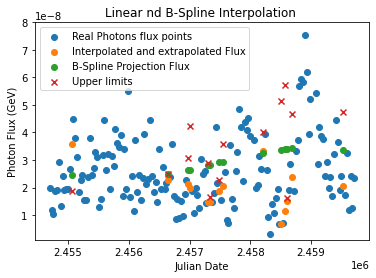

In [2]:
#Plotting data for one light curve
plt.scatter(JD,FLUX_points,label="Real Photons flux points")
plt.scatter(UPTIME,Interp_proj,label="Interpolated and extrapolated Flux")
plt.scatter(UPTIME,Bspline_proj,label="B-Spline Projection Flux")
plt.scatter(UPTIME,UP,marker='x',label="Upper limits")
plt.title("Linear and B-Spline Interpolation ")
plt.ylim(0.01*10**(-7),0.8*10**(-7))
plt.xlabel("Julian Date")
plt.ylabel("Photon Flux (GeV)")
plt.legend()
plt.show()

In [35]:
new_csv.head()

,Date(UTC),Julian Date,MET,TS,Photon Flux [0.1-100 GeV](photons cm-2 s-1),Photon Flux Error(photons cm-2 s-1),Photon Index,Photon Index Error,Fit Tolerance,MINUIT Return Code,Analysis Log
0,Aug 20 2008,2454699,240883201,23.80,3.569661e-08,6.90e-9,-2.07,-,1.000000e-08,0,bin1.log
1,Sep 19 2008,2454729,243475201,5.30,2.271695e-08,6.42e-9,-2.07,-,1.000000e-08,0,bin2.log
2,Oct 19 2008,2454759,246067201,4.30,2.133333e-08,6.19e-9,-2.07,-,1.000000e-08,0,bin3.log
3,Nov 18 2008,2454788,248659201,24.78,1.996667e-08,6.10e-9,-2.07,-,1.000000e-08,0,bin4.log
4,Dec 18 2008,2454819,251251201,19.79,1.456813e-08,6.80e-9,-2.07,-,1.000000e-08,0,bin5.log


In [36]:
LC.head()

,Date(UTC),Julian Date,MET,TS,Photon Flux [0.1-100 GeV](photons cm-2 s-1),Photon Flux Error(photons cm-2 s-1),Photon Index,Photon Index Error,Fit Tolerance,MINUIT Return Code,Analysis Log
0,Aug 20 2008,2454699,240883201,23.80,1.99e-8,6.90e-9,-2.07,-,1.000000e-08,0,bin1.log
1,Sep 19 2008,2454729,243475201,5.30,1.18e-8,6.42e-9,-2.07,-,1.000000e-08,0,bin2.log
2,Oct 19 2008,2454759,246067201,4.30,1.02e-8,6.19e-9,-2.07,-,1.000000e-08,0,bin3.log
3,Nov 18 2008,2454788,248659201,24.78,1.89e-8,6.10e-9,-2.07,-,1.000000e-08,0,bin4.log
4,Dec 18 2008,2454819,251251201,19.79,1.91e-8,6.80e-9,-2.07,-,1.000000e-08,0,bin5.log


In [166]:
#Looping with data files
#Interpolation/extrapolation code

# for i in range(len(data_files)):
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.interpolate
import re
import csv
import warnings
import json
import matplotlib
matplotlib.use('tkAgg') # 'tkAgg' if Qt not present 
import scipy as sp
import matplotlib.animation as animation
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Data location
path_of_the_directory= "C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/INTERPODATA/"

data_files = []
file_names = []

Saving_Folder_adress= "C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/Interpolated data/"

#Storing in a list the adresses of all the data files in the notebook
for filename in os.listdir(path_of_the_directory):
    f = os.path.join(path_of_the_directory,filename)
    if os.path.isfile(f):
        data_files.append(f)
        file_names.append(filename)
                              
# removing special character for the upper limits 
special_char = re.compile('<')

#Function to convert from strings to float and separate upper limits
#and flux data points

def Filterup(data):
    
    Flux= data['Photon Flux [0.1-100 GeV](photons cm-2 s-1)']
    Time = data['Julian Date']
    
    Flux = np.array(Flux)
    Time=Time.astype(float)
    
    #Non upperlimits flux data and corresponding index
    FLUXTIME = []
    FLUXTIME_index = []
    
    
    UPTIME = []
    UpperLINDEX=  []
    UpperLimits=[]
    
    for i in range(len(Flux)):
        
        if(special_char.search(Flux[i]) == None):
                FLUXTIME.append(Time[i])
                FLUXTIME_index.append(i)
        else:  
            UpperLINDEX.append(i)            
            Flux[i]=Flux[i].replace('< ', '')
            
            UPTIME.append(Time[i])
            
    Flux=Flux.astype(float)
    FULL_FLUX_array=Flux.copy()
    FULL_TIME=Time.copy()
    
    for j in range(len(UpperLINDEX)):
        
        j=0
        i = UpperLINDEX[j]-j
        UpperLimits.append(Flux[i])
        Flux = np.delete(Flux,i)
        j=j-1
        
    
    UpperLimits=np.array(UpperLimits)    
    UpperLimits=UpperLimits.astype(float)
    UPTIME=np.array(UPTIME) 
    UPTIME=UPTIME.astype(float)
    
    return Flux,UpperLimits,FLUXTIME,UpperLINDEX,UPTIME,FLUXTIME_index,FULL_TIME,FULL_FLUX_array
    

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def LSTM_prediction(FLUX):
    
    FLUX=np.reshape(FLUX,(len(FLUX),1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    FLUX = scaler.fit_transform(FLUX)

    # split into train and test sets
    train_size = int(len(FLUX) * 0.8)
    test_size = len(FLUX) - train_size
    train, test = FLUX[0:train_size,:], FLUX[train_size:len(FLUX),:]

    # reshape into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, epochs=800, batch_size=4, verbose=0)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    trainPredictPlot = np.empty_like(FLUX)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(FLUX)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(FLUX)-1, :] = testPredict
    print(testY)
    # print(trainPredict)
    # print(testPredict)

    F_error = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    
    return testY,F_error

     
file_adress = data_files[-1]
LC=pd.read_csv(file_adress)




#Function calling
FLUX_points,UP,JD,UPindex,UPTIME,FTI,FT_array,FF_array= Filterup(LC)

#Linear interpolation and extrapolation
flux_extrapolate = scipy.interpolate.interp1d(JD,FLUX_points,fill_value='extrapolate')
flux_interp = scipy.interpolate.interp1d(JD, FLUX_points)

#Bspline interpolation



FULLPROJ=[]
interpolated_flux_LSTM=[]
interpolated_flux=[]
extrapolated_flux1= []



Flux_error_array=[]



if FTI[0]>UPindex[0]:

    for j in range(FTI[0]):
        a = flux_extrapolate(FT_array[j])
        extrapolated_flux1.append(a)
        FF_array[j]=a

    UPindex = [x for x in UPindex if x>FTI[0]]
    FULLPROJ=extrapolated_flux1

else : 
        UPindex = [x for x in UPindex if x>=FTI[0]]
        

for j in range(len(UPindex)):
    c = UPindex[j]
    a = flux_interp(FT_array[c])
    interpolated_flux.append(a)
    
    if c<14:
        interpolated_flux_LSTM.append(a)
        FF_array[j]=a
    if c>14:
        FLUX_LSTM = FF_array[0:c]
        LSTM_pred,Flux_err = LSTM_prediction(FLUX_LSTM)
        interpolated_flux_LSTM.append(LSTM_pred[0][-1])
        Flux_error_array.append(Flux_err)
        FF_array[j]=LSTM_pred[0][-1]
        
    





print("Done ! ")


#Full sequenced array with only interpolated/extrapolated points


[[1.70e-08 3.39e-08 1.95e-08 5.51e-08 1.64e-08 2.41e-08 1.16e-08 3.73e-08
  1.83e-08 2.46e-08 1.56e-08]]
[[1.83e-08 2.46e-08 1.56e-08 2.35e-08 3.95e-08 2.13e-08 2.32e-08 4.44e-08
  2.41e-08 1.82e-08 2.21e-08 1.46e-08 3.39e-08 1.96e-08]]
[[2.46e-08 1.56e-08 2.35e-08 3.95e-08 2.13e-08 2.32e-08 4.44e-08 2.41e-08
  1.82e-08 2.21e-08 1.46e-08 3.39e-08 1.96e-08 2.75e-08]]
[[1.82e-08 2.21e-08 1.46e-08 3.39e-08 1.96e-08 2.75e-08 1.94e-08 2.17e-08
  2.37e-08 3.58e-08 1.70e-08 8.59e-09 1.57e-08 9.10e-09 1.50e-08 9.69e-09]]
[[2.21e-08 1.46e-08 3.39e-08 1.96e-08 2.75e-08 1.94e-08 2.17e-08 2.37e-08
  3.58e-08 1.70e-08 8.59e-09 1.57e-08 9.10e-09 1.50e-08 9.69e-09 1.75e-08]]
[[2.75e-08 1.94e-08 2.17e-08 2.37e-08 3.58e-08 1.70e-08 8.59e-09 1.57e-08
  9.10e-09 1.50e-08 9.69e-09 1.75e-08 2.27e-08 1.86e-08 1.08e-08 1.99e-08
  1.72e-08]]
[[2.17e-08 2.37e-08 3.58e-08 1.70e-08 8.59e-09 1.57e-08 9.10e-09 1.50e-08
  9.69e-09 1.75e-08 2.27e-08 1.86e-08 1.08e-08 1.99e-08 1.72e-08 1.24e-08
  3.03e-08]]
[[2.48e-0

In [167]:
#Plotting data for one light curve
plt.scatter(JD,FLUX_points,label="Real Photons flux points")
plt.scatter(UPTIME,interpolated_flux,label="Interpolated and extrapolated Flux")
plt.scatter(UPTIME,interpolated_flux_LSTM,label="LSTM Flux Prediction")
plt.scatter(UPTIME,UP,marker='x',label="Upper limits")
plt.title("Linear Interpolation and LSTM Prediction")
plt.ylim(0.01*10**(-7),0.8*10**(-7))
plt.xlabel("Julian Date")
plt.ylabel("Photon Flux (GeV)")
plt.legend()
plt.show()

In [168]:
for i in range(len(data_files)):
    file_adress = data_files[i]
    LC=pd.read_csv(file_adress)
    FLUX_points,UP,JD,UPindex,UPTIME,FTI,FT_array,FF_array= Filterup(LC)
    print(i,len(UPindex))

0 91
1 139
2 127
3 22
4 111
5 104
6 132
7 86
8 14


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

FLUX = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
FLUX=np.arange(10)
# FLUX=FLUX.astype(float)
FLUX=np.reshape(FLUX,(len(FLUX),1))

scaler = MinMaxScaler(feature_range=(0, 1))
FLUX = scaler.fit_transform(FLUX)
 
# split into train and test sets
train_size = int(len(FLUX) * 0.9)
test_size = len(FLUX) - train_size
train, test = FLUX[0:train_size,:], FLUX[train_size:len(FLUX),:]



print(test)
# convert an array of values into a FLUXTRAIN matrix
# reshape into X=t and Y=t+1


def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)



# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=900, batch_size=4, verbose=0)



# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

print(testPredict)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainPredictPlot = np.empty_like(FLUX)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(FLUX)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(FLUX)-1, :] = testPredict
print(testY)
# print(trainPredict)
# print(testPredict)

print(math.sqrt(mean_squared_error(testY[0], testPredict[:,0])))